# Is "queer" more positive for Woolf than for male modernists?

A notebook demonstrating how you could confirm your answer to that question statistically and with confidence.

Short version: yes, you were right.

In [1]:
from gensim.utils import simple_preprocess
from smart_open import smart_open
import os
from gensim import corpora
from pprint import pprint

In [2]:
from random import choices
from scipy.spatial.distance import cosine
import numpy as np

### Bootstrap sample "paragraphs" from Woolf

Instead of paragraphs, we're really going to be using sentence triplets.

I'm grouping sentences because I don't know how much the word2vec training runs across sentence boundaries. If it does, randomizing sentences one by one might lose some information.

In [3]:
with open('C:\\Users\\Heejoung Shin\\Documents\\Heejoung Files\\UIUC MSLIS\\IS417-Data Science in the Humanities\\Research Paper\\Data\\woolfcorpus.txt', encoding = 'latin-1') as f:
    woolflines = f.readlines()

In [4]:
def paragraphize(linelist): 
    paragraphlist = []
    sentence = []
    scount = 0
    for line in linelist:
        words = line.strip().split()
        for w in words:
            if not w.endswith('.'):
                sentence.append(w)
            elif scount < 2:
                sentence.append(w)
                scount += 1
            else:
                scount = 0
                sentence.append(w)
                stext = ' '.join(sentence)
                sentence = []
                paragraphlist.append(stext)
    print(len(linelist), len(paragraphlist))
    
    return paragraphlist

In [5]:
woolflines[57]

'chair.  The curious gleam which had come into all their eyes when\n'

In [6]:
paragraphlist = paragraphize(woolflines)

166559 31471


In [7]:
paragraphlist[10]

"The curious gleam which had come into all their eyes when Major Elkin began his story had faded completely from Colonel Pargiter's face. He sat staring ahead of him with bright blue eyes that seemed a little screwed up, as if the glare of the East were still in them; and puckered at the corners as if the dust were still in them. Some thought had struck him that made what the others were saying of no interest to him; indeed, it was disagreeable to him."

In [8]:
import gensim
import gensim.models
from gensim.test.utils import datapath
from gensim import utils
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string

### Lists of positive and negative words

There are many such lists in circulation. We happen to be using a list created by Bing Liu, available at

https://urldefense.com/v3/__https://ptrckprry.com/course/ssd/data/positive-words.txt*5Cn__;JQ!!DZ3fjg!ocdPDmxGKI3cM5KWMy4Lk5CvwWUKaVGNHHq7NmKxe-bnlu7HeocNyT0goglSyzLN$ 
https://urldefense.com/v3/__https://ptrckprry.com/course/ssd/data/negative-words.txt*5Cn__;JQ!!DZ3fjg!ocdPDmxGKI3cM5KWMy4Lk5CvwWUKaVGNHHq7NmKxe-bnlu7HeocNyT0gony6LFX4$ 
citation:

Bing Liu, Minqing Hu and Junsheng Cheng. "Opinion Observer: Analyzing and Comparing Opinions on the Web." Proceedings of the 14th International World Wide Web conference (WWW-2005), May 10-14, 2005, Chiba, Japan.

In [9]:
with open('C:\\Users\\Heejoung Shin\\Documents\\Heejoung Files\\UIUC MSLIS\\IS417-Data Science in the Humanities\\Research Paper\\Data\\liunegative.txt', encoding = 'utf-8') as f:
    negative_words = [x.strip() for x in f.readlines()]
    
with open('C:\\Users\\Heejoung Shin\\Documents\\Heejoung Files\\UIUC MSLIS\\IS417-Data Science in the Humanities\\Research Paper\\Data\\liupositive.txt', encoding = 'utf-8') as f:
    positive_words = [x.strip() for x in f.readlines()]

In [10]:
def get_vector(wordlist, model): 
    vectors = []
    
    for ex in wordlist:    # for each word in a wordlist
        if ex in model.wv:
            vec = model.wv[ex]    # get its vector
            vectorlength = np.linalg.norm(vec, ord = 2)     # normalize length
            vectors.append(vec / vectorlength)              # and save it in a list
        
    thesum = np.sum(vectors, axis = 0)                  # then add all the vectors
    vectorlength = np.linalg.norm(thesum, ord = 2)      # normalize length again
    
    return thesum / vectorlength


### Create multiple Woolf models

We're interested in assessing the stability of the thesis that Woolf uses "queer" in a more positive sense than Joyce, Fitzgerald, and Lawrence.

Can we assert that statement generally? Is it highly dependent on one or two passages, or does it really hold together across the oeuvre of the authors in question?

One way to assess this is to run multiple models on different subsamples of both corpora. In each case we can measure the distance from "queer" to positive words, and negative words, and the difference between the distances. 

Since we're measuring distance rather than similarity, the positivity of "queer" can be assessed as

    negative_distance - positive_distance

If we run, say, five models for each corpus, do we see any stable pattern?

In [45]:
woolf_sims = []
pos_distances = []
neg_distances = []
woolf_net_positive = []


for i in range (10):
    woolfsample = choices(paragraphlist, k = len(paragraphlist))

    # random.choices samples with repetition.
    # So each time we run this, we're creating a different bootstrap sample of
    # "paragraphs" from the sentence list.

    #loading txt file and turning it into courpus
    class MyCorpus:
        def __iter__(self):
            global woolfsample    
            for line in woolfsample:
                yield gensim.utils.simple_preprocess(line)

    sentences = MyCorpus()

    model = gensim.models.Word2Vec(sentences, iter=10)

    sims = model.wv.most_similar('queer', topn=100)  # get other similar words
    woolf_sims.append(sims)

    pos_vector = get_vector(positive_words, model)
    neg_vector = get_vector(negative_words, model)
    vec_queer = model.wv['queer']
    
    pos_dist = cosine(vec_queer, pos_vector)
    neg_dist = cosine(vec_queer, neg_vector)
    pos_distances.append(pos_dist)
    neg_distances.append(neg_dist)
    
    net_positive_queer = neg_dist - pos_dist
    
    print(i, net_positive_queer)
    
    woolf_net_positive.append(net_positive_queer)


0 0.02984565496444702
1 0.04312220215797424
2 0.030261218547821045
3 0.017677471041679382
4 0.03118079900741577
5 0.028796449303627014
6 0.04449121654033661
7 0.0338318794965744
8 0.06414829194545746
9 0.020061522722244263


The output above tells us, in short, that "queer" is always more positive than negative for Woolf. It's not a giant difference, and it varies a lot in size. But there's usually a lean toward the positive.

We can also look at the specific distances involved for each run of the model:

In [14]:
for i in range(5):
    print(round(neg_distances[i], 4), round(pos_distances[i], 4))

0.8297 0.8152
0.7734 0.7407
0.8058 0.7807
0.774 0.7231
0.7545 0.7338


### Now run multiple models for Joyce, Fitzgerald, and Lawrence

We'll just repeat the same steps. First load and paragraphize the corpus:

In [15]:
with open('C:\\Users\\Heejoung Shin\\Documents\\Heejoung Files\\UIUC MSLIS\\IS417-Data Science in the Humanities\\Research Paper\\Data\\joyce_fitzgerald_lawrence_corpus.txt', encoding = 'latin-1') as f:
    jfllines = f.readlines()

In [16]:
jflparagraphs = paragraphize(jfllines)

410809 75300


Then run five models and measure net positivity in each case.

In [17]:
jfl_sims = []
jfl_pos_distances = []
jfl_neg_distances = []
jfl_net_positive = []

for i in range(10):
    jflsample = choices(jflparagraphs, k = len(jflparagraphs))

    # random.choices samples with repetition.
    # So each time we run this, we're creating a different bootstrap sample of
    # "paragraphs" from the sentence list.

    #loading txt file and turning it into courpus
    class MyCorpus:
        def __iter__(self):
            global jflsample    
            for line in jflsample:
                yield gensim.utils.simple_preprocess(line)

    sentences = MyCorpus()

    model = gensim.models.Word2Vec(sentences, iter=10)

    sims = model.wv.most_similar('queer', topn=100)  # get other similar words
    jfl_sims.append(sims)

    pos_vector = get_vector(positive_words, model)
    neg_vector = get_vector(negative_words, model)
    vec_queer = model.wv['queer']
    
    pos_dist = cosine(vec_queer, pos_vector)
    neg_dist = cosine(vec_queer, neg_vector)
    jfl_pos_distances.append(pos_dist)
    jfl_neg_distances.append(neg_dist)
    
    net_positive_queer = neg_dist - pos_dist
    jfl_net_positive.append(net_positive_queer)
    
    print(i, net_positive_queer)



0 -0.010129541158676147
1 -0.035021230578422546
2 -0.016061559319496155
3 -0.025298237800598145
4 -0.03434884548187256
5 -0.012533366680145264
6 -0.0475660115480423
7 -0.03012832999229431
8 -0.015756577253341675
9 -0.014452427625656128


We can see that for these authors, the word "queer" is usually slightly more negative than positive. It's not always true! There's one positive number, which does overlap slightly with a couple of Woolf's models. But it looks like the central tendency here is pretty different from the tendency for Woolf.

Let's confirm that formally, using [a T test.](https://urldefense.com/v3/__https://www.scribbr.com/statistics/t-test/__;!!DZ3fjg!ocdPDmxGKI3cM5KWMy4Lk5CvwWUKaVGNHHq7NmKxe-bnlu7HeocNyT0goouiEOj9$ )

In [18]:
from scipy.stats import ttest_ind

In [19]:
ttest_ind(woolf_net_positive, jfl_net_positive)

Ttest_indResult(statistic=8.809998941246375, pvalue=6.044038017650719e-08)

The p value there tells us that the difference of means between these samples would not be very likely to occur by chance if these samples were drawn from populations that actually had the same mean value.

You can say confidently that this word is more positive for Woolf than it is for Joyce, Fitzgerald, and Lawrence (considered collectively). How far this holds for each of those three authors individually would be a separate question — but that's also probably much further than you need to go in this project.

In [20]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

In [58]:
boxplotdata = pd.DataFrame({'net_positivity': woolf_net_positive + jfl_net_positive, 'author': ['Woolf'] * 10 + ['JFL'] * 10})

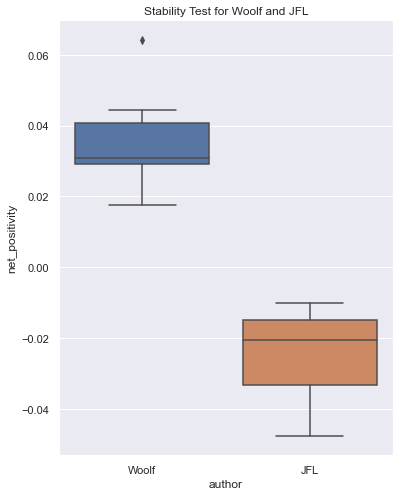

In [59]:
sns.set(rc={'figure.figsize':(6, 8)})
sns_plot = sns.boxplot(x = 'author', y = 'net_positivity', data = boxplotdata)
fig = sns_plot.get_figure()
plt.title("Stability Test for Woolf and JFL")
fig.savefig("boxplot_woolf_jfl.png")
plt.show()

### This time, let's get individual male authors. Let's start with Joyce.

In [23]:
with open('C:\\Users\\Heejoung Shin\\Documents\\Heejoung Files\\UIUC MSLIS\\IS417-Data Science in the Humanities\\Research Paper\\Data\\joycecorpus.txt', encoding = 'latin-1') as f:
    jfllines = f.readlines()

In [24]:
jparagraphs = paragraphize(jlines)

33647 9609


In [40]:
j_sims = []
j_pos_distances = []
j_neg_distances = []
j_net_positive = []

for i in range(10):
    jsample = choices(jparagraphs, k = len(jparagraphs))

    # random.choices samples with repetition.
    # So each time we run this, we're creating a different bootstrap sample of
    # "paragraphs" from the sentence list.

    #loading txt file and turning it into courpus
    class MyCorpus:
        def __iter__(self):
            global jsample    
            for line in jsample:
                yield gensim.utils.simple_preprocess(line)

    sentences = MyCorpus()

    model = gensim.models.Word2Vec(sentences, iter=10)

    sims = model.wv.most_similar('queer', topn=100)  # get other similar words
    j_sims.append(sims)

    pos_vector = get_vector(positive_words, model)
    neg_vector = get_vector(negative_words, model)
    vec_queer = model.wv['queer']
    
    pos_dist = cosine(vec_queer, pos_vector)
    neg_dist = cosine(vec_queer, neg_vector)
    j_pos_distances.append(pos_dist)
    j_neg_distances.append(neg_dist)
    
    net_positive_queer = neg_dist - pos_dist
    j_net_positive.append(net_positive_queer)
    
    print(i, net_positive_queer)



0 0.020460307598114014
1 0.029211580753326416
2 0.025097906589508057
3 0.02371448278427124
4 0.030085742473602295
5 0.020095348358154297
6 0.03134411573410034
7 0.02500760555267334
8 0.027004480361938477
9 0.0049713850021362305


In [25]:
from scipy.stats import ttest_ind

In [50]:
ttest_ind(woolf_net_positive, j_net_positive)

Ttest_indResult(statistic=2.179211606525822, pvalue=0.042844310720461895)

### Now it is Fitzgerald's turn.

In [26]:
with open('C:\\Users\\Heejoung Shin\\Documents\\Heejoung Files\\UIUC MSLIS\\IS417-Data Science in the Humanities\\Research Paper\\Data\\fitzgeraldcorpus.txt', encoding = 'latin-1') as f:
    flines = f.readlines()

In [27]:
fparagraphs = paragraphize(flines)

83012 11290


In [29]:
f_sims = []
f_pos_distances = []
f_neg_distances = []
f_net_positive = []

for i in range(10):
    fsample = choices(fparagraphs, k = len(fparagraphs))

    # random.choices samples with repetition.
    # So each time we run this, we're creating a different bootstrap sample of
    # "paragraphs" from the sentence list.

    #loading txt file and turning it into courpus
    class MyCorpus:
        def __iter__(self):
            global fsample    
            for line in fsample:
                yield gensim.utils.simple_preprocess(line)

    sentences = MyCorpus()

    model = gensim.models.Word2Vec(sentences, iter=10)

    sims = model.wv.most_similar('queer', topn=100)  # get other similar words
    f_sims.append(sims)

    pos_vector = get_vector(positive_words, model)
    neg_vector = get_vector(negative_words, model)
    vec_queer = model.wv['queer']
    
    pos_dist = cosine(vec_queer, pos_vector)
    neg_dist = cosine(vec_queer, neg_vector)
    f_pos_distances.append(pos_dist)
    f_neg_distances.append(neg_dist)
    
    net_positive_queer = neg_dist - pos_dist
    f_net_positive.append(net_positive_queer)
    
    print(i, net_positive_queer)



0 0.01885199546813965
1 0.003959298133850098
2 0.02892845869064331
3 0.023720979690551758
4 0.0244901180267334
5 0.04531586170196533
6 0.012361705303192139
7 0.01324915885925293
8 0.047923147678375244
9 0.02302372455596924


In [51]:
ttest_ind(woolf_net_positive, f_net_positive)

Ttest_indResult(statistic=1.6629159064004138, pvalue=0.11364325257928456)

### Finally, let's get Lawrence.

In [30]:
with open('C:\\Users\\Heejoung Shin\\Documents\\Heejoung Files\\UIUC MSLIS\\IS417-Data Science in the Humanities\\Research Paper\\Data\\lawrencecorpus.txt', encoding = 'latin-1') as f:
    llines = f.readlines()

In [31]:
lparagraphs = paragraphize(llines)

294149 54401


In [32]:
l_sims = []
l_pos_distances = []
l_neg_distances = []
l_net_positive = []

for i in range(10):
    lsample = choices(lparagraphs, k = len(lparagraphs))

    # random.choices samples with repetition.
    # So each time we run this, we're creating a different bootstrap sample of
    # "paragraphs" from the sentence list.

    #loading txt file and turning it into courpus
    class MyCorpus:
        def __iter__(self):
            global lsample    
            for line in lsample:
                yield gensim.utils.simple_preprocess(line)

    sentences = MyCorpus()

    model = gensim.models.Word2Vec(sentences, iter=10)

    sims = model.wv.most_similar('queer', topn=100)  # get other similar words
    l_sims.append(sims)

    pos_vector = get_vector(positive_words, model)
    neg_vector = get_vector(negative_words, model)
    vec_queer = model.wv['queer']
    
    pos_dist = cosine(vec_queer, pos_vector)
    neg_dist = cosine(vec_queer, neg_vector)
    l_pos_distances.append(pos_dist)
    l_neg_distances.append(neg_dist)
    
    net_positive_queer = neg_dist - pos_dist
    l_net_positive.append(net_positive_queer)
    
    print(i, net_positive_queer)



0 -0.009097427129745483
1 -0.017985999584197998
2 -0.02185189723968506
3 -0.00016921758651733398
4 -0.021677881479263306
5 -0.0016668736934661865
6 0.014635056257247925
7 -0.006867080926895142
8 -0.014697492122650146
9 0.012068241834640503


For Lawrence, it is worth performing a T-test, as we now know that he is the player who is mainly responsible for associating queer with negative words. Below shows that it is unlikely 

In [34]:
ttest_ind(woolf_net_positive, l_net_positive)

Ttest_indResult(statistic=5.894252453743602, pvalue=1.40052889766125e-05)

### Now, let's add Joseph Conrad

In [66]:
with open('C:\\Users\\Heejoung Shin\\Documents\\Heejoung Files\\UIUC MSLIS\\IS417-Data Science in the Humanities\\Research Paper\\Data\\conradcorpus.txt', encoding = 'latin-1') as f:
    clines = f.readlines()

In [67]:
cparagraphs = paragraphize(clines)

200460 43875


In [68]:
c_sims = []
c_pos_distances = []
c_neg_distances = []
c_net_positive = []

for i in range(10):
    csample = choices(cparagraphs, k = len(cparagraphs))

    # random.choices samples with repetition.
    # So each time we run this, we're creating a different bootstrap sample of
    # "paragraphs" from the sentence list.

    #loading txt file and turning it into courpus
    class MyCorpus:
        def __iter__(self):
            global csample    
            for line in csample:
                yield gensim.utils.simple_preprocess(line)

    sentences = MyCorpus()

    model = gensim.models.Word2Vec(sentences, iter=10)

    sims = model.wv.most_similar('queer', topn=100)  # get other similar words
    c_sims.append(sims)

    pos_vector = get_vector(positive_words, model)
    neg_vector = get_vector(negative_words, model)
    vec_queer = model.wv['queer']
    
    pos_dist = cosine(vec_queer, pos_vector)
    neg_dist = cosine(vec_queer, neg_vector)
    c_pos_distances.append(pos_dist)
    c_neg_distances.append(neg_dist)
    
    net_positive_queer = neg_dist - pos_dist
    c_net_positive.append(net_positive_queer)
    
    print(i, net_positive_queer)



0 0.041653066873550415
1 0.03466230630874634
2 0.027008473873138428
3 0.02608388662338257
4 0.02556060254573822
5 0.00840313732624054
6 0.02373473346233368
7 0.034248724579811096
8 0.002868056297302246
9 0.04377853870391846


Conrad t-test

In [69]:
ttest_ind(woolf_net_positive, c_net_positive)

Ttest_indResult(statistic=1.2693442155432015, pvalue=0.22048577931603436)

In [60]:
boxplotdata = pd.DataFrame({'net_positivity': woolf_net_positive + j_net_positive + f_net_positive + l_net_positive, 'author': ['Woolf'] * 10 + ['Joyce'] * 10 + ['Fitzgerald'] * 10 + ['Lawrence'] * 10})

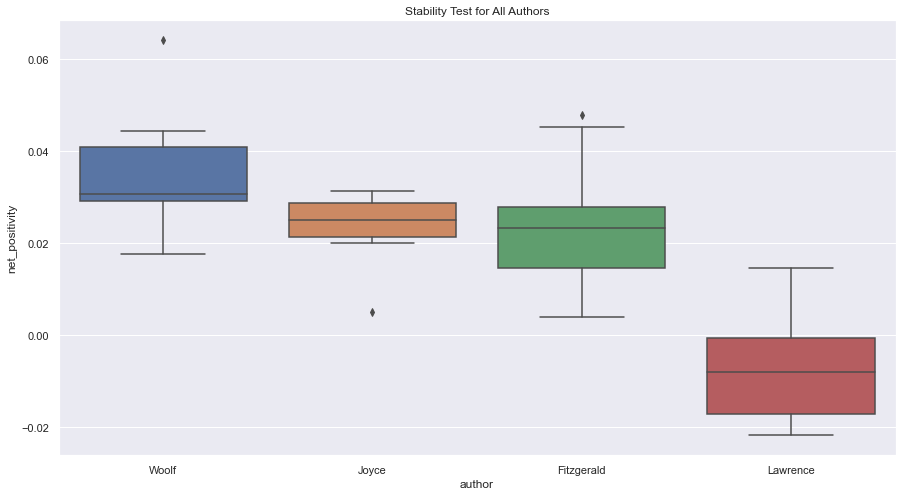

In [61]:
sns.set(rc={'figure.figsize':(15, 8)})
sns_plot = sns.boxplot(x = 'author', y = 'net_positivity', data = boxplotdata)
fig = sns_plot.get_figure()
plt.title("Stability Test for All Authors")
fig.savefig("boxplot_allauthors4.png")
plt.show()

In [56]:
boxplotdata = pd.DataFrame({'net_positivity': woolf_net_positive + j_net_positive + f_net_positive + l_net_positive + jfl_net_positive, 'author': ['Woolf'] * 10 + ['Joyce'] * 10 + ['Fitzgerald'] * 10 + ['Lawrence'] * 10 + ['JFL'] * 10})

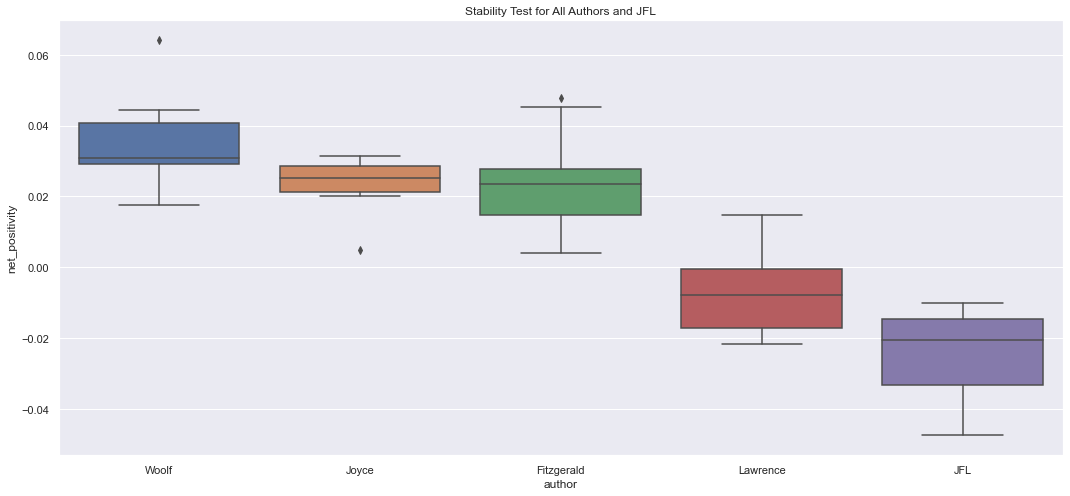

In [57]:
sns.set(rc={'figure.figsize':(18, 8)})
sns_plot = sns.boxplot(x = 'author', y = 'net_positivity', data = boxplotdata)
fig = sns_plot.get_figure()
plt.title("Stability Test for All Authors and JFL")
fig.savefig("boxplot_allauthors_jfl3.png")
plt.show()